# Convolutional Neural Network

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import jupyprint.jupyprint as jp
import matplotlib.pyplot as plt

import CNN_class

DL = CNN_class.CNN()

## Train and Test Mnist Conv

In [ ]:
import numpy as np

# Load data
Images = loadMNISTImages('MNIST/t10k-images.idx3-ubyte')
Labels = loadMNISTLabels('MNIST/t10k-labels.idx1-ubyte')

np.random.seed(1)

W1 = 1e-2 * np.random.randn(9, 9, 20)
W5 = (2 * np.random.rand(100, 2000) - 1) * np.sqrt(6) / np.sqrt(360 + 2000)
Wo = (2 * np.random.rand(10, 100) - 1) * np.sqrt(6) / np.sqrt(10 + 100)

X = Images[:, :, :7000]
D = Labels[:7000]

# Training
for epoch in range(10):
    print("Epoch:", epoch + 1)
    W1, W5, Wo = SGD_MnistConv(W1, W5, Wo, X, D)

# Save model weights
with h5py.File('MnistConv.h5', 'w') as hf:
    hf.create_dataset('W1', data=W1)
    hf.create_dataset('W5', data=W5)
    hf.create_dataset('Wo', data=Wo)

# Evaluation
X_test = Images[:, :, 7001:10000]
D_test = Labels[7001:10000]
acc = 0
N = len(D_test)

for k in range(N):
    print("Sample:", k + 1)
    x = X_test[:, :, k]
    y1 = Conv(x, W1)
    y2 = ReLU(y1)
    y3 = Pool(y2)
    y4 = y3.flatten()
    v5 = np.dot(W5, y4)
    y5 = ReLU(v5)
    v = np.dot(Wo, y5)
    y = Softmax(v)
    
    i = np.argmax(y)
    if i == D_test[k]:
        acc += 1

acc = acc / N
print('Accuracy is %f' % acc)


In [8]:
import numpy as np
import gzip

def load_MNIST_images(filename):
	with gzip.open(filename, 'r') as f:
		# first 4 bytes is a magic number
		magic_number    = int.from_bytes(f.read(4), 'big')
		# second 4 bytes is the number of images
		image_count     = int.from_bytes(f.read(4), 'big')
		# third 4 bytes is the row count
		row_count       = int.from_bytes(f.read(4), 'big')
		# fourth 4 bytes is the column count
		column_count    = int.from_bytes(f.read(4), 'big')
		
		# rest is the image pixel data, each pixel is stored as an unsigned byte
		# pixel values are 0 to 255
		images = np.frombuffer(f.read(), dtype=np.uint8)\
			.reshape((image_count, row_count, column_count))
	# images.shape --> (10000, 28, 28)
	return images


def load_MNIST_labels(filename):
	with gzip.open(filename, 'r') as f:
		# first 4 bytes is a magic number
		magic_number    = int.from_bytes(f.read(4), 'big')
		# second 4 bytes is the number of labels
		label_count     = int.from_bytes(f.read(4), 'big')
		
		# rest is the label data, each label is stored as unsigned byte
		# label values are 0 to 9
		label_data      = f.read()
		labels = np.frombuffer(label_data, dtype=np.uint8)
	# labels.shape --> (10000,)
	return labels

images = load_MNIST_images('t10k-images-idx3-ubyte.gz')
labels = load_MNIST_labels('t10k-labels-idx1-ubyte.gz')

In [9]:
print('images shape', images.shape)
print('labels shape', labels.shape)

images shape (10000, 28, 28)
labels shape (10000,)


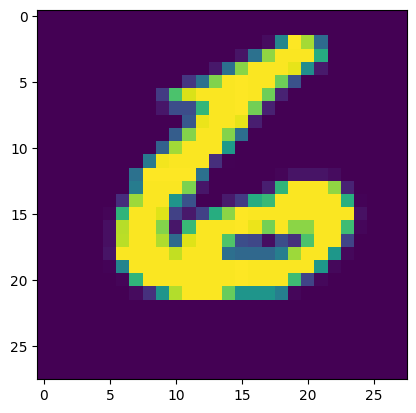

In [12]:
import matplotlib.pyplot as plt
# image = np.asarray(images[0]).squeeze()
plt.imshow(images[9999])
plt.show()

Pool

In [ ]:
def Pool(x):
    xrow, xcol, numFilters = x.shape
    y = np.zeros((xrow // 2, xcol // 2, numFilters))
    
    for k in range(numFilters):
        filter = np.ones((2, 2)) / 4  # Creiamo un filtro di media 2x2
        image = convolve2d(x[:, :, k], filter, mode='valid')  # Calcoliamo la media su 4 pixel
        y[:, :, k] = image[::2, ::2]  # Prendiamo la media e la mettiamo in un pixel ogni 4
     
    return y

# Esempio di utilizzo:
x = np.random.rand(6, 6, 3)  # Creiamo un esempio di input 6x6 con 3 filtri
y = pool(x)
print(y)
